In [1]:
using_colab = False
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

import os
# if using Apple MPS, fall back to CPU for unsupported ops
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["HYDRA_FULL_ERROR"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor
import subprocess
import pandas as pd
import math
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy.interpolate import make_interp_spline
from scipy.spatial import ConvexHull

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [2]:
sam2_checkpoint = "/home/ipd/CV_Models/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

frame_rate = 2
PROJECT_NAME = "Object_Tracking"          
PROJECT_NAME = PROJECT_NAME + "_" + str(frame_rate) + "fps" 
INPUT_VIDEO_NAME = "9953_Act_03.mp4"


INPUT_VIDEO_PATH = os.path.join("videos", INPUT_VIDEO_NAME)
PROJECT_DIRECTORY_PATH = "results/" + INPUT_VIDEO_NAME.replace(".mp4", "_" + PROJECT_NAME)
OUTPUT_VIDEO_NAME = INPUT_VIDEO_NAME.replace(".mp4", "_" + PROJECT_NAME + ".mp4")
OUTPUT_VIDEO_PATH = os.path.join(os.path.join(PROJECT_DIRECTORY_PATH, "videos"), OUTPUT_VIDEO_NAME)
OUTPUT_TRAJECTORY_NAME = OUTPUT_VIDEO_NAME.replace(".mp4", ".csv")
OUTPUT_TRAJECTORY_PATH = os.path.join(os.path.join(PROJECT_DIRECTORY_PATH, "trajectories"), OUTPUT_TRAJECTORY_NAME)
OUTPUT_TRAJECTORY_IMAGE_NAME = OUTPUT_VIDEO_NAME.replace(".mp4", ".png")
OUTPUT_TRAJECTORY_IMAGE_PATH = os.path.join(os.path.join(PROJECT_DIRECTORY_PATH, "trajectories"), OUTPUT_TRAJECTORY_IMAGE_NAME)
OUTPUT_MASK_MATRIX_NAME = OUTPUT_VIDEO_NAME.replace(".mp4", ".npy")
OUTPUT_MASK_MATRIX_PATH = os.path.join(os.path.join(PROJECT_DIRECTORY_PATH, "trajectories"), OUTPUT_MASK_MATRIX_NAME)    
# print(OUTPUT_TRAJECTORY_IMAGE_PATH)
VIDEO_FRAME_PATH = os.path.join(PROJECT_DIRECTORY_PATH, "frames")
OUTPUT_MASK_PATH = os.path.join(PROJECT_DIRECTORY_PATH, "masks")



In [3]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [4]:
frame_names = [
    p for p in os.listdir(VIDEO_FRAME_PATH)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))


In [5]:
inference_state = predictor.init_state(video_path=VIDEO_FRAME_PATH)

frame loading (JPEG): 100%|██████████| 1200/1200 [00:30<00:00, 38.78it/s]


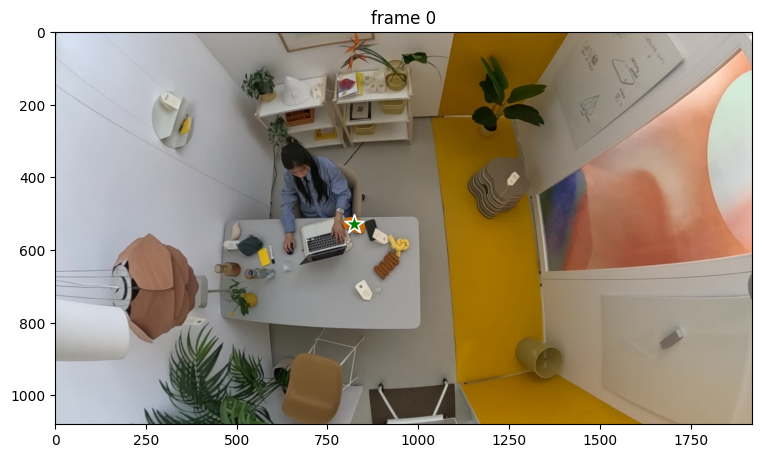

In [6]:
ann_frame_idx = 0  
ann_obj_id = 1  

points = np.array([[823,527]], dtype=np.float32)
# for labels, `1` means positive click (what you want) and `0` means negative click (what you don't want)
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(VIDEO_FRAME_PATH, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

In [7]:
# video_segments = {}  # video_segments contains the per-frame segmentation results
results = []
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    # video_segments[out_frame_idx] = {
    #     out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
    #     for i, out_obj_id in enumerate(out_obj_ids)
    # }
    results.append((out_mask_logits[0] > 0.0).cpu().numpy())

np.save(OUTPUT_MASK_MATRIX_PATH, results)
    

propagate in video: 100%|██████████| 1200/1200 [00:46<00:00, 25.94it/s]


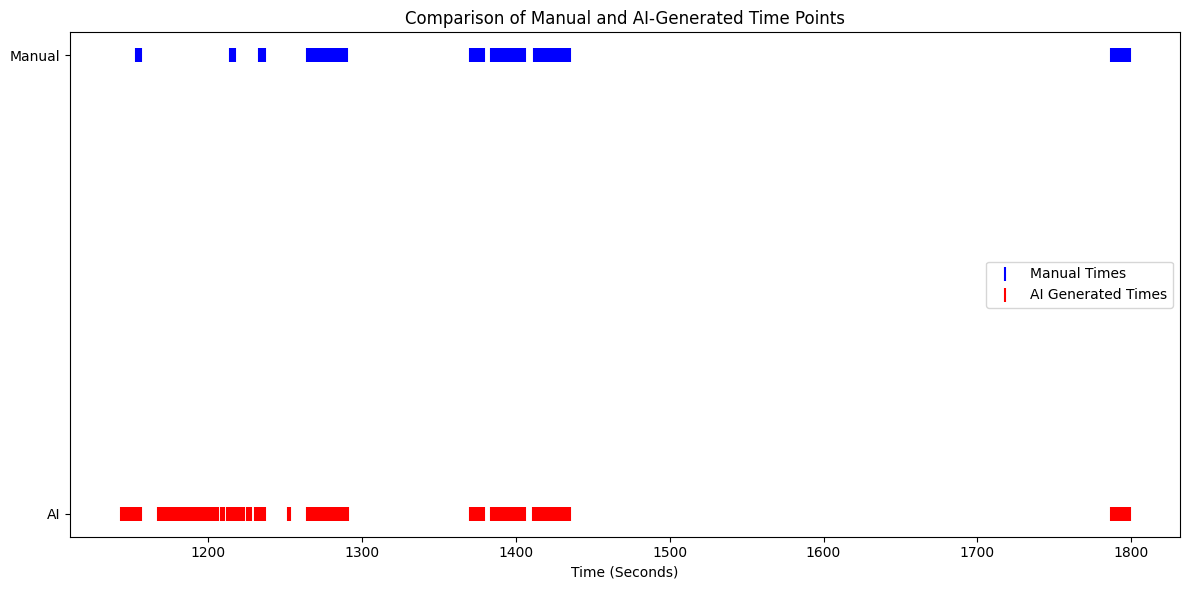

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def time_to_seconds(time_str):
    """
    将时间字符串转换为秒数。
    :param time_str: 时间字符串 (HH:MM:SS)
    :return: 转换后的秒数
    """
    t = datetime.strptime(time_str, "%H:%M:%S")
    return t.hour * 3600 + t.minute * 60 + t.second

# 读取 CSV 文件
manual_csv = "/home/ipd/Scripts/SAM2/results/9953_Act_Overlap/real_times.csv"  # 手动标注时间 CSV 文件路径
ai_csv = "/home/ipd/Scripts/SAM2/results/9953_Act_Overlap/prediect_times.csv"  # AI 生成时间 CSV 文件路径

manual_df = pd.read_csv(manual_csv)
ai_df = pd.read_csv(ai_csv)

# 将时间转换为秒数
manual_df["Seconds"] = manual_df["Time"].apply(time_to_seconds)
ai_df["Seconds"] = ai_df["Time"].apply(time_to_seconds)

# 绘制对比图
plt.figure(figsize=(12, 6))

# 手动标注时间线
plt.scatter(manual_df["Seconds"], [1] * len(manual_df), color="blue", label="Manual Times", marker="|", s=100)

# AI 生成时间线
plt.scatter(ai_df["Seconds"], [0] * len(ai_df), color="red", label="AI Generated Times", marker="|", s=100)

# 添加图例和标签
plt.yticks([0, 1], ["AI", "Manual"])
plt.xlabel("Time (Seconds)")
plt.title("Comparison of Manual and AI-Generated Time Points")
plt.legend()

# 显示图像
plt.tight_layout()
plt.show()